In [33]:
import pandas as pd
import numpy as np
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [2]:
pro_frames_merge = pd.read_csv('pro_frames_merge_2v2.csv', index_col = 0)
not_ol = ['HB', 'WR', 'FB']
pro_frames_merge = pro_frames_merge[(~pro_frames_merge['position_in'].isin(not_ol)) &
                                    (~pro_frames_merge['position_out'].isin(not_ol))]

In [1075]:
features = ['frame_from_snap', 
            'frame_from_overlap',
            'width_in','width_out', 
            'depth_in', 'depth_out',
            's_in','s_out',
            'a_in', 'a_out',
            'squareness_in', 'squareness_out',
            'open_outside_in', 'open_outside_out', 
            'moving_outside_in', 'moving_outside_out',
            'rotation_in', 'rotation_out',
            'rotation_outside_in', 'rotation_outside_out',
            'qb_o_rel_in', 'qb_o_rel_out',
            'qb_squareness_in', 'qb_squareness_out',
            'qb_dist_in', 'qb_dist_out',
            'x_diff', 'y_diff', 'dist', 'min_qb_dist', 'rel_rotation', 'penetrator_depth', 
            'mean_squareness', 'dev_squareness', 'max_squareness',
            'mean_qb_squareness', 'dev_qb_squareness', 'max_qb_squareness',
            #'position_combo', 
            'stunt_type', 'exchange']

In [1076]:
df = pro_frames_merge[features + ['rush_win']]
corr_matrix = df.corr()
win_corr = corr_matrix['rush_win'][:-1]
i = 1
pair_list = []
for col in corr_matrix.iloc[:-1,1:-1].columns:
    corr_search = corr_matrix[col][:i]
    high_corrs = corr_search[corr_search.abs() >= 0.65]
    if len(high_corrs) > 0:
        pairs = list(zip([col]*len(high_corrs),high_corrs.index,high_corrs.values))
        pair_list = pair_list + pairs
    i += 1
dfhc = pd.DataFrame(pair_list, columns = ['feat1','feat2','corr'])
chosen_features = ['penetrator_depth', 'mean_qb_squareness', 'min_qb_dist']
df_chosen = dfhc[(dfhc['feat1'].isin(chosen_features)) | (dfhc['feat2'].isin(chosen_features))]
removed_features = [feat for feat in (set(df_chosen['feat1']) | set(df_chosen['feat2'])) if feat not in chosen_features]
df_remaining = dfhc[(~dfhc['feat1'].isin(removed_features)) & (~dfhc['feat2'].isin(removed_features))]
df_remaining

,feat1,feat2,corr


In [1077]:
features2 = [feat for feat in features if feat not in removed_features]
df = pro_frames_merge[features2 + ['rush_win']]
corr_matrix = df.corr()
features2

['width_in',
 'width_out',
 's_in',
 's_out',
 'a_in',
 'a_out',
 'squareness_in',
 'squareness_out',
 'open_outside_in',
 'open_outside_out',
 'moving_outside_in',
 'moving_outside_out',
 'rotation_in',
 'rotation_out',
 'rotation_outside_in',
 'rotation_outside_out',
 'qb_o_rel_in',
 'qb_o_rel_out',
 'x_diff',
 'y_diff',
 'dist',
 'min_qb_dist',
 'rel_rotation',
 'penetrator_depth',
 'mean_qb_squareness',
 'stunt_type',
 'exchange']

1

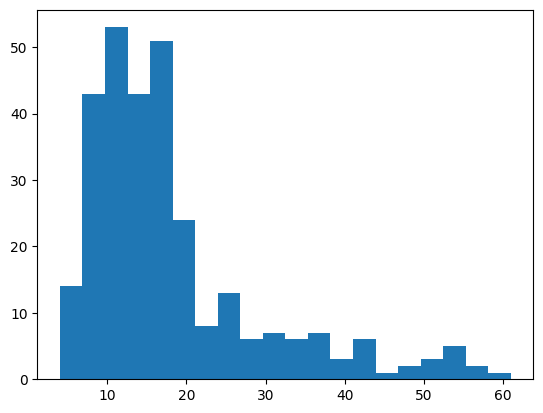

In [97]:
win_frames = wins.groupby(['gameId','playId','stuntId'])['frame_from_overlap'].max()
plt.hist(win_frames, bins = 20)
len(win_frames[win_frames < 5])

11

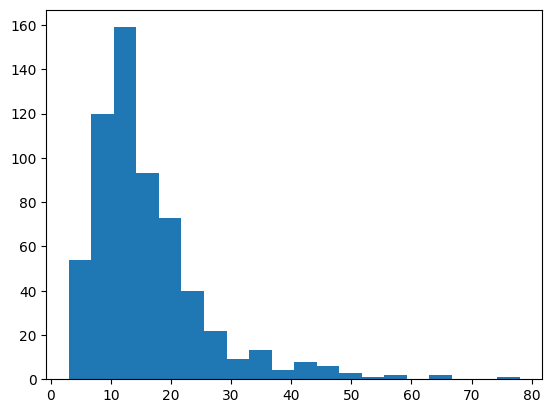

In [98]:
loss_frames = losses.groupby(['gameId','playId','stuntId'])['frame_from_overlap'].max()
plt.hist(loss_frames, bins = 20)
len(loss_frames[loss_frames < 5])

In [1078]:
len(pro_frames_merge)

31872

In [1184]:
remove_features = ['a_in', 'a_out', 
                   'squareness_in', 'squareness_out',
                   'qb_o_rel_in', 'qb_o_rel_out',
                   'open_outside_in', 'open_outside_out',
                   'rotation_in', 'rotation_out',
                   'moving_outside_in', 'moving_outside_out',
                   'rotation_outside_in', 'rotation_outside_out',
                   #'rel_rotation',
                   'width_out', 'dist']
features3 = [feat for feat in features2 if feat not in remove_features]
features3

['width_in',
 's_in',
 's_out',
 'x_diff',
 'y_diff',
 'min_qb_dist',
 'rel_rotation',
 'penetrator_depth',
 'mean_qb_squareness',
 'stunt_type',
 'exchange']

In [1348]:
pro_frames_merge['stunt_type'] = pro_frames_merge['stunt_type'].astype('category')
pro_frames_merge_trunc = pro_frames_merge[pro_frames_merge['frame_from_overlap'].isin(range(-7,11))]
X = pro_frames_merge_trunc[features3]
y = pro_frames_merge_trunc['rush_win']
train_frames = pro_frames_merge_trunc[pro_frames_merge_trunc['gameId'] < 2021102100]
test_frames = pro_frames_merge_trunc[pro_frames_merge_trunc['gameId'] >= 2021102100]
X_train = train_frames[features3]
y_train = train_frames['rush_win']
X_test = test_frames[features3]
y_test = test_frames['rush_win']

In [1349]:
X_train.dtypes

width_in               float64
s_in                   float64
s_out                  float64
x_diff                 float64
y_diff                 float64
min_qb_dist            float64
rel_rotation           float64
penetrator_depth       float64
mean_qb_squareness     float64
stunt_type            category
exchange                  bool
dtype: object

In [1350]:
sum(y_test) / len(y_test)

0.3371165644171779

In [1351]:
clf = xgb.XGBClassifier(objective = 'binary:logistic', 
                        seed=123,
                        tree_method = 'approx',
                        eval_metric = 'auc',
                        base_score = 0.33,
                        enable_categorical = True,
                        early_stopping_rounds = 10)
clf.fit(X_train,
        y_train,
        verbose = True, 
        eval_set = [(X_test, y_test)])

[0]	validation_0-auc:0.63956
[1]	validation_0-auc:0.67233
[2]	validation_0-auc:0.68737
[3]	validation_0-auc:0.68913
[4]	validation_0-auc:0.69002
[5]	validation_0-auc:0.68992
[6]	validation_0-auc:0.68695
[7]	validation_0-auc:0.69219
[8]	validation_0-auc:0.69416
[9]	validation_0-auc:0.69345
[10]	validation_0-auc:0.69066
[11]	validation_0-auc:0.69264
[12]	validation_0-auc:0.69573
[13]	validation_0-auc:0.69959
[14]	validation_0-auc:0.69716
[15]	validation_0-auc:0.69700
[16]	validation_0-auc:0.70024
[17]	validation_0-auc:0.69869
[18]	validation_0-auc:0.69693
[19]	validation_0-auc:0.69890
[20]	validation_0-auc:0.69890
[21]	validation_0-auc:0.69281
[22]	validation_0-auc:0.69267
[23]	validation_0-auc:0.68869
[24]	validation_0-auc:0.68792
[25]	validation_0-auc:0.68606
[26]	validation_0-auc:0.68791


XGBClassifier(base_score=0.33, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=True,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123, ...)

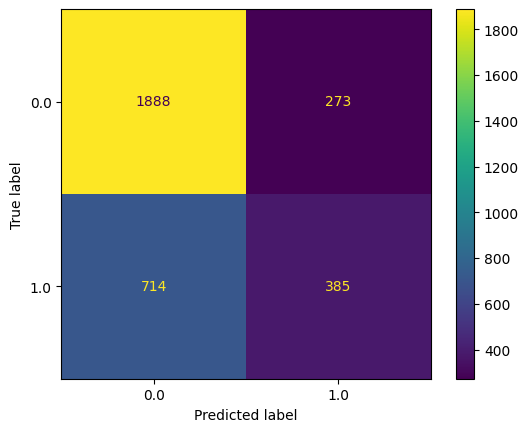

In [1352]:
ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

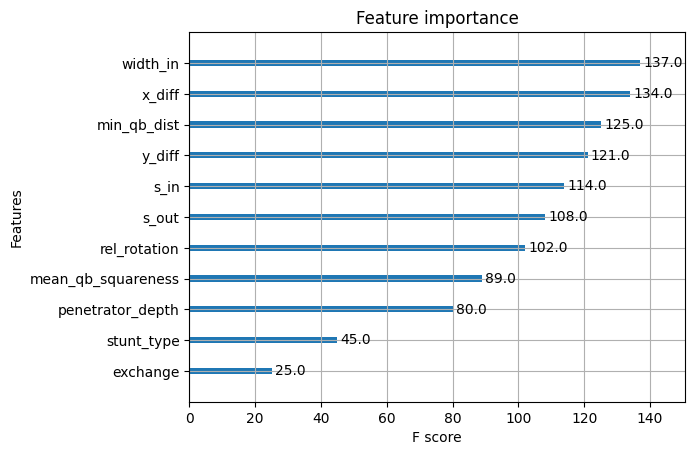

In [1353]:
xgb.plot_importance(clf)

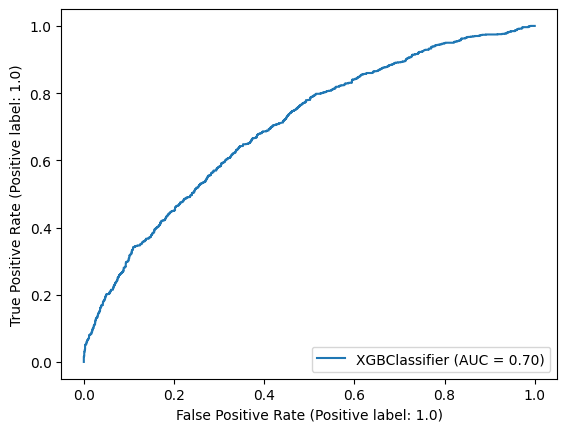

In [1354]:
RocCurveDisplay.from_estimator(clf,X_test,y_test)

In [1355]:
tf = test_frames.copy()
tf['proba'] = clf.predict_proba(X_test)[:,1]
tf['pred'] = np.where(tf['proba'] >= .5, 1.0, 0.0)
tf['accuracy'] = np.where(tf['rush_win'] == tf['pred'], 1.0, 0.0)

In [1356]:
by_frame = tf.groupby('frame_from_overlap')['proba'].mean().to_frame()
by_frame['proba_if_win'] = tf[tf['rush_win'] == 1.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['proba_if_loss'] = tf[tf['rush_win'] == 0.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['proba_diff'] = by_frame['proba_if_win'] - by_frame['proba_if_loss']
by_frame['pred'] = tf.groupby('frame_from_overlap')['pred'].mean()
by_frame['accuracy'] = tf.groupby('frame_from_overlap')['accuracy'].mean()
by_frame['sensitivity'] = tf[tf['rush_win'] == 1.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['false_pos_rate'] = tf[tf['rush_win'] == 0.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['specificity'] = 1 - by_frame['false_pos_rate']
by_frame['precision'] = tf[tf['pred'] == 1.0].groupby('frame_from_overlap')['rush_win'].mean()
by_frame[:50]

,proba,proba_if_win,proba_if_loss,proba_diff,pred,accuracy,sensitivity,false_pos_rate,specificity,precision
frame_from_overlap,,,,,,,,,,
-7,0.296009,0.307633,0.290244,0.017388,0.122995,0.631016,0.129032,0.120000,0.880000,0.347826
-6,0.295766,0.317918,0.284778,0.033140,0.117647,0.657754,0.161290,0.096000,0.904000,0.454545
-5,0.309056,0.337223,0.295085,0.042138,0.155080,0.620321,0.161290,0.152000,0.848000,0.344828
-4,0.309953,0.340167,0.295086,0.045081,0.170213,0.627660,0.193548,0.158730,0.841270,0.375000
-3,0.302707,0.330112,0.289222,0.040891,0.138298,0.627660,0.145161,0.134921,0.865079,0.346154
-2,0.303781,0.364892,0.273711,0.091181,0.148936,0.659574,0.209677,0.119048,0.880952,0.464286
-1,0.304597,0.392523,0.261332,0.131192,0.154255,0.696809,0.274194,0.095238,0.904762,0.586207
0,0.313838,0.409695,0.266670,0.143025,0.175532,0.696809,0.306452,0.111111,0.888889,0.575758
1,0.321950,0.435226,0.266211,0.169015,0.202128,0.702128,0.354839,0.126984,0.873016,0.578947


(array([ 68.,  44.,  99., 140., 132., 145., 144., 122., 121., 122., 120.,
        109.,  93.,  88.,  63.,  61.,  56.,  52.,  32.,  30.,  42.,  35.,
         23.,  20.,  18.,  27.,  19.,  30.,  16.,  14.,  10.,  12.,  12.,
         16.,   6.,   7.,   7.,   2.,   2.,   2.]),
 array([0.01082241, 0.03377855, 0.0567347 , 0.07969084, 0.10264699,
        0.12560314, 0.14855927, 0.17151542, 0.19447157, 0.21742772,
        0.24038386, 0.26334   , 0.28629616, 0.30925229, 0.33220842,
        0.35516459, 0.37812072, 0.40107688, 0.42403302, 0.44698915,
        0.46994531, 0.49290144, 0.51585758, 0.53881377, 0.5617699 ,
        0.58472604, 0.60768217, 0.6306383 , 0.65359449, 0.67655063,
        0.69950676, 0.72246289, 0.74541903, 0.76837522, 0.79133135,
        0.81428748, 0.83724362, 0.86019975, 0.88315594, 0.90611207,
        0.92906821]),
 <BarContainer object of 40 artists>)

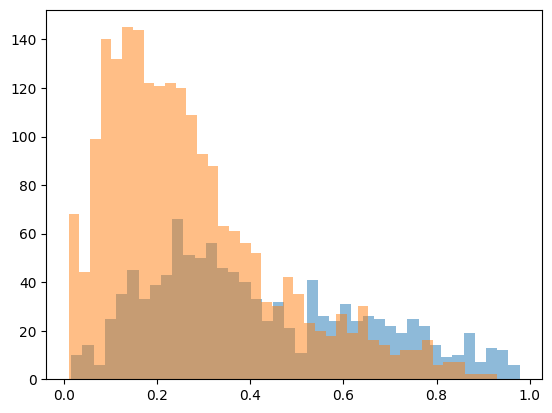

In [1357]:
plt.hist(tf[tf['rush_win'] == 1]['proba'], bins = 40, alpha = 0.5)
plt.hist(tf[tf['rush_win'] == 0]['proba'], bins = 40, alpha = 0.5)

In [1358]:
tf[tf['rush_win'] == 0][['proba', 'pred', 'accuracy']].describe()

,proba,pred,accuracy
count,2161.000000,2161.000000,2161.000000
mean,0.270801,0.126330,0.873670
std,0.182791,0.332298,0.332298
min,0.010822,0.000000,0.000000
25%,0.133800,0.000000,1.000000
50%,0.229249,0.000000,1.000000
75%,0.359386,0.000000,1.000000
max,0.929068,1.000000,1.000000


In [1359]:
param_grid = {
    'max_depth': [3, 4, 5, 6], 
    'learning_rate': [0.3, 0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  seed = 123,
                                  subsample = 0.9,
                                  colsample_bytree = 0.5,
                                  eval_metric = 'auc',
                                  early_stopping_rounds = 10,
                                  tree_method = 'approx',
                                  enable_categorical = True
                                  ),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose = 2,
    n_jobs = 10,
    cv = 3)

In [1360]:
optimal_params.fit(X_train, 
                   y_train, 
                   eval_set = [(X_test, y_test)])

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[0]	validation_0-auc:0.63295
[1]	validation_0-auc:0.66909
[2]	validation_0-auc:0.68343
[3]	validation_0-auc:0.68783
[4]	validation_0-auc:0.68142
[5]	validation_0-auc:0.68536
[6]	validation_0-auc:0.69045
[7]	validation_0-auc:0.69078
[8]	validation_0-auc:0.69671
[9]	validation_0-auc:0.69526
[10]	validation_0-auc:0.69503
[11]	validation_0-auc:0.69683
[12]	validation_0-auc:0.69947
[13]	validation_0-auc:0.69775
[14]	validation_0-auc:0.69690
[15]	validation_0-auc:0.69974
[16]	validation_0-auc:0.69903
[17]	validation_0-auc:0.70250
[18]	validation_0-auc:0.70135
[19]	validation_0-auc:0.70042
[20]	validation_0-auc:0.70089
[21]	validation_0-auc:0.70330
[22]	validation_0-auc:0.70262
[23]	validation_0-auc:0.70397
[24]	validation_0-auc:0.70355
[25]	validation_0-auc:0.70429
[26]	validation_0-auc:0.70424
[27]	validation_0-auc:0.70289
[28]	validation_0-auc:0.70093
[29]	validation_0-auc:0.70092
[30]	validation_0-auc:0.70304
[31]	validation_

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     early_stopping_rounds=10,
                                     enable_categorical=True, eval_metric='auc',
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.3, 0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5, 6],
                         'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc', verbose=2)

In [1361]:
optimal_params.best_params_

{'gamma': 0.25,
 'learning_rate': 0.05,
 'max_depth': 5,
 'reg_lambda': 1.0,
 'scale_pos_weight': 1}

In [1362]:
param_grid = {
    'max_depth': [5], 
    'learning_rate': [0.05],
    'gamma': [0.25],
    'reg_lambda': [1.0],
    'scale_pos_weight': [1, 2]
}
optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                  seed = 123,
                                  subsample = 0.9,
                                  colsample_bytree = 0.5,
                                  eval_metric = 'auc',
                                  early_stopping_rounds = 10,
                                  tree_method = 'approx',
                                  enable_categorical = True
                                  ),
    param_grid = param_grid,
    scoring = 'roc_auc',
    verbose = 2,
    n_jobs = 10,
    cv = 3)

In [1363]:
optimal_params.fit(X_train, 
                   y_train, 
                   eval_set = [(X_test, y_test)])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[0]	validation_0-auc:0.63295
[1]	validation_0-auc:0.66909
[2]	validation_0-auc:0.68343
[3]	validation_0-auc:0.68783
[4]	validation_0-auc:0.68142
[5]	validation_0-auc:0.68536
[6]	validation_0-auc:0.69045
[7]	validation_0-auc:0.69078
[8]	validation_0-auc:0.69671
[9]	validation_0-auc:0.69526
[10]	validation_0-auc:0.69503
[11]	validation_0-auc:0.69683
[12]	validation_0-auc:0.69947
[13]	validation_0-auc:0.69775
[14]	validation_0-auc:0.69690
[15]	validation_0-auc:0.69974
[16]	validation_0-auc:0.69903
[17]	validation_0-auc:0.70250
[18]	validation_0-auc:0.70135
[19]	validation_0-auc:0.70042
[20]	validation_0-auc:0.70089
[21]	validation_0-auc:0.70330
[22]	validation_0-auc:0.70262
[23]	validation_0-auc:0.70397
[24]	validation_0-auc:0.70355
[25]	validation_0-auc:0.70429
[26]	validation_0-auc:0.70424
[27]	validation_0-auc:0.70289
[28]	validation_0-auc:0.70093
[29]	validation_0-auc:0.70092
[30]	validation_0-auc:0.70304
[31]	validation_0-auc

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     early_stopping_rounds=10,
                                     enable_categorical=True, eval_metric='auc',
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0.25], 'learning_rate': [0.05],
                         'max_depth': [5], 'reg_lambda': [1.0],
                         'scale_pos_weight': [1, 2]},
             scoring='roc_auc', verbose=2)

In [1364]:
optimal_params.best_params_

{'gamma': 0.25,
 'learning_rate': 0.05,
 'max_depth': 5,
 'reg_lambda': 1.0,
 'scale_pos_weight': 1}

In [1365]:
clf_tuned = xgb.XGBClassifier(objective = 'binary:logistic', 
                        seed=123,
                        tree_method = 'approx',
                        eval_metric = 'auc',
                        gamma = 0.25,
                        eta = 0.05,
                        max_depth = 5,
                        reg_lambda = 1.0,
                        scale_pos_weight = 1,
                        subsample = 0.9,
                        colsample_bytree = 0.5,
                        base_score = 0.33,
                        enable_categorical = True,
                        early_stopping_rounds = 10)
clf_tuned.fit(X_train,
        y_train,
        verbose = True, 
        eval_set = [(X_test, y_test)])

[0]	validation_0-auc:0.63249
[1]	validation_0-auc:0.67298
[2]	validation_0-auc:0.67584
[3]	validation_0-auc:0.68066
[4]	validation_0-auc:0.67574
[5]	validation_0-auc:0.68250
[6]	validation_0-auc:0.68811
[7]	validation_0-auc:0.68894
[8]	validation_0-auc:0.69449
[9]	validation_0-auc:0.69462
[10]	validation_0-auc:0.69551
[11]	validation_0-auc:0.69720
[12]	validation_0-auc:0.69800
[13]	validation_0-auc:0.69530
[14]	validation_0-auc:0.69471
[15]	validation_0-auc:0.69788
[16]	validation_0-auc:0.69816
[17]	validation_0-auc:0.70112
[18]	validation_0-auc:0.70065
[19]	validation_0-auc:0.69967
[20]	validation_0-auc:0.70029
[21]	validation_0-auc:0.70179
[22]	validation_0-auc:0.70175
[23]	validation_0-auc:0.70294
[24]	validation_0-auc:0.70265
[25]	validation_0-auc:0.70337
[26]	validation_0-auc:0.70415
[27]	validation_0-auc:0.70253
[28]	validation_0-auc:0.70141
[29]	validation_0-auc:0.70105
[30]	validation_0-auc:0.70316
[31]	validation_0-auc:0.70258
[32]	validation_0-auc:0.70272
[33]	validation_0-au

XGBClassifier(base_score=0.33, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=10, enable_categorical=True, eta=0.05,
              eval_metric='auc', feature_types=None, gamma=0.25, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0500000007,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

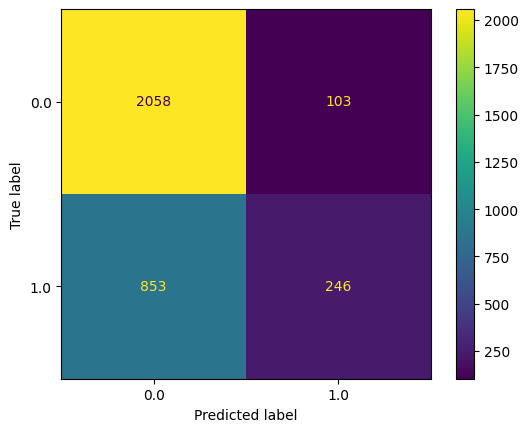

In [1366]:
ConfusionMatrixDisplay.from_estimator(clf_tuned,X_test,y_test)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

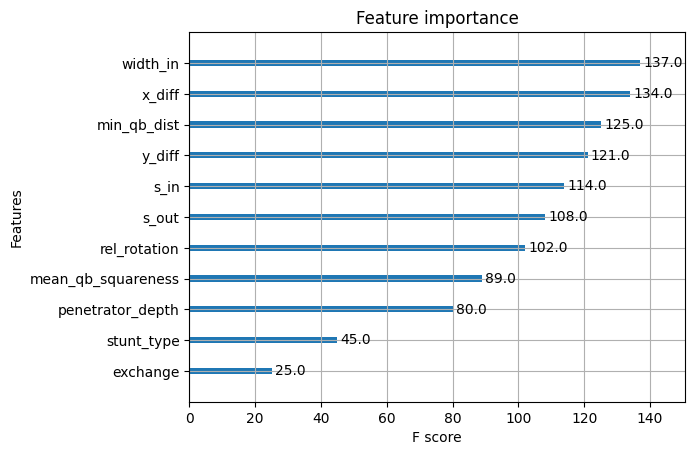

In [1367]:
xgb.plot_importance(clf)

In [1368]:
tf = test_frames.copy()
tf['proba'] = clf_tuned.predict_proba(X_test)[:,1]
tf['pred'] = np.where(tf['proba'] >= .5, 1.0, 0.0)
tf['accuracy'] = np.where(tf['rush_win'] == tf['pred'], 1.0, 0.0)

In [1369]:
by_frame = tf.groupby('frame_from_overlap')['proba'].mean().to_frame()
by_frame['proba_if_win'] = tf[tf['rush_win'] == 1.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['proba_if_loss'] = tf[tf['rush_win'] == 0.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['pred'] = tf.groupby('frame_from_overlap')['pred'].mean()
by_frame['accuracy'] = tf.groupby('frame_from_overlap')['accuracy'].mean()
by_frame['sensitivity'] = tf[tf['rush_win'] == 1.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['false_pos_rate'] = tf[tf['rush_win'] == 0.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['specificity'] = 1 - by_frame['false_pos_rate']
by_frame['precision'] = tf[tf['pred'] == 1.0].groupby('frame_from_overlap')['rush_win'].mean()
by_frame

,proba,proba_if_win,proba_if_loss,pred,accuracy,sensitivity,false_pos_rate,specificity,precision
frame_from_overlap,,,,,,,,,
-7,0.288202,0.296836,0.283919,0.005348,0.663102,0.000000,0.008000,0.992000,0.000000
-6,0.292337,0.301308,0.287887,0.000000,0.668449,0.000000,0.000000,1.000000,NaN
-5,0.297930,0.308103,0.292884,0.005348,0.663102,0.000000,0.008000,0.992000,0.000000
-4,0.301227,0.313821,0.295030,0.021277,0.659574,0.016129,0.023810,0.976190,0.250000
-3,0.305258,0.321777,0.297130,0.031915,0.648936,0.016129,0.039683,0.960317,0.166667
-2,0.310199,0.337232,0.296897,0.047872,0.664894,0.064516,0.039683,0.960317,0.444444
-1,0.315423,0.360527,0.293229,0.069149,0.686170,0.129032,0.039683,0.960317,0.615385
0,0.321391,0.377321,0.293870,0.085106,0.691489,0.161290,0.047619,0.952381,0.625000
1,0.325693,0.388781,0.294650,0.101064,0.696809,0.193548,0.055556,0.944444,0.631579


(array([  2.,  10.,  19.,  41.,  51., 104., 183., 244., 231., 214., 145.,
        106., 101.,  92.,  80.,  80.,  68.,  51.,  49.,  38.,  31.,  41.,
         35.,  35.,  20.,  18.,  19.,  11.,  11.,   7.,   1.,   4.,   3.,
          5.,   3.,   3.,   2.,   0.,   1.,   2.]),
 array([0.10049262, 0.11695102, 0.13340943, 0.14986782, 0.16632622,
        0.18278463, 0.19924302, 0.21570143, 0.23215984, 0.24861823,
        0.26507664, 0.28153503, 0.29799345, 0.31445184, 0.33091024,
        0.34736866, 0.36382705, 0.38028544, 0.39674386, 0.41320226,
        0.42966065, 0.44611907, 0.46257746, 0.47903585, 0.49549428,
        0.5119527 , 0.52841109, 0.54486948, 0.56132787, 0.57778627,
        0.59424466, 0.61070311, 0.6271615 , 0.64361989, 0.66007829,
        0.67653668, 0.69299507, 0.70945352, 0.72591192, 0.74237031,
        0.7588287 ]),
 <BarContainer object of 40 artists>)

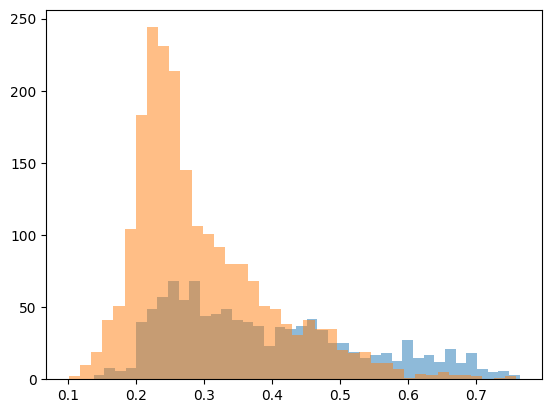

In [1370]:
plt.hist(tf[tf['rush_win'] == 1]['proba'], bins = 40, alpha = 0.5)
plt.hist(tf[tf['rush_win'] == 0]['proba'], bins = 40, alpha = 0.5)

(array([ 5.,  6., 11.,  8., 19., 34., 61., 66., 41., 57., 43., 23., 22.,
        26., 15., 18., 16., 16.,  9., 10.,  9., 11.,  5., 11., 15., 13.,
         8.,  9.,  8.,  5.,  7.,  6.,  4.,  3.,  5.,  1.,  0.,  0.,  2.,
         1.]),
 array([0.12218716, 0.13539478, 0.14860241, 0.16181004, 0.17501767,
        0.1882253 , 0.20143293, 0.21464056, 0.22784819, 0.24105582,
        0.25426346, 0.26747108, 0.28067872, 0.29388633, 0.30709395,
        0.32030159, 0.33350921, 0.34671685, 0.35992447, 0.37313211,
        0.38633972, 0.39954737, 0.41275498, 0.42596263, 0.43917024,
        0.45237789, 0.4655855 , 0.47879314, 0.49200076, 0.50520837,
        0.51841605, 0.53162366, 0.54483128, 0.55803889, 0.57124656,
        0.58445418, 0.59766179, 0.61086941, 0.62407708, 0.6372847 ,
        0.65049231]),
 <BarContainer object of 40 artists>)

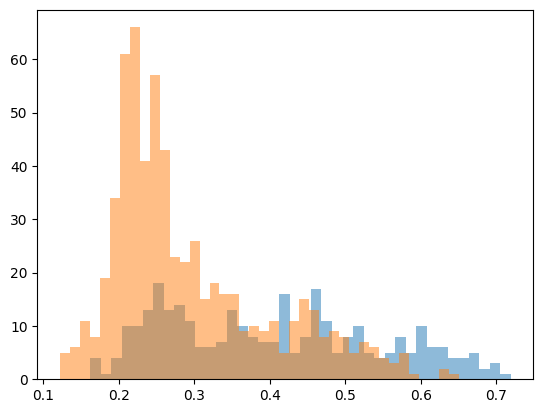

In [1371]:
tf_late = tf[tf['frame_from_overlap'].isin(range(0,5))]
plt.hist(tf_late[tf_late['rush_win'] == 1]['proba'], bins = 40, alpha = 0.5)
plt.hist(tf_late[tf_late['rush_win'] == 0]['proba'], bins = 40, alpha = 0.5)

In [1372]:
af = pro_frames_merge_trunc.copy()
af['proba'] = clf_tuned.predict_proba(af[features3])[:,1]
af['pred'] = np.where(af['proba'] >= .5, 1.0, 0.0)
af['accuracy'] = np.where(af['rush_win'] == af['pred'], 1.0, 0.0)

In [1373]:
by_frame = af.groupby('frame_from_overlap')['proba'].mean().to_frame()
by_frame['proba_if_win'] = af[af['rush_win'] == 1.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['proba_if_loss'] = af[af['rush_win'] == 0.0].groupby('frame_from_overlap')['proba'].mean()
by_frame['proba_diff'] = by_frame['proba_if_win'] - by_frame['proba_if_loss']
by_frame['pred'] = af.groupby('frame_from_overlap')['pred'].mean()
by_frame['accuracy'] = af.groupby('frame_from_overlap')['accuracy'].mean()
by_frame['sensitivity'] = af[af['rush_win'] == 1.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['false_pos_rate'] = af[af['rush_win'] == 0.0].groupby('frame_from_overlap')['pred'].mean()
by_frame['specificity'] = 1 - by_frame['false_pos_rate']
by_frame['precision'] = af[af['pred'] == 1.0].groupby('frame_from_overlap')['rush_win'].mean()
by_frame

,proba,proba_if_win,proba_if_loss,proba_diff,pred,accuracy,sensitivity,false_pos_rate,specificity,precision
frame_from_overlap,,,,,,,,,,
-7,0.292571,0.317426,0.280388,0.037038,0.014349,0.678808,0.033557,0.004934,0.995066,0.769231
-6,0.295551,0.324977,0.281129,0.043848,0.017660,0.684327,0.046980,0.003289,0.996711,0.875000
-5,0.299979,0.334244,0.283184,0.051060,0.019868,0.686534,0.053691,0.003289,0.996711,0.888889
-4,0.303217,0.343535,0.283488,0.060047,0.029768,0.690187,0.073826,0.008210,0.991790,0.814815
-3,0.307092,0.354500,0.283932,0.070568,0.040749,0.697137,0.100671,0.011475,0.988525,0.810811
-2,0.311120,0.367745,0.283457,0.084288,0.061674,0.713656,0.157718,0.014754,0.985246,0.839286
-1,0.315303,0.384575,0.281462,0.103112,0.077093,0.722467,0.194631,0.019672,0.980328,0.828571
0,0.321847,0.405155,0.281148,0.124006,0.096916,0.731278,0.238255,0.027869,0.972131,0.806818
1,0.327706,0.423417,0.280948,0.142469,0.117841,0.745595,0.291946,0.032787,0.967213,0.813084


(array([ 30.,  79., 192., 271., 441., 613., 681., 825., 966., 811., 668.,
        546., 490., 405., 305., 291., 256., 237., 190., 169., 139., 126.,
        104.,  74.,  78.,  71.,  44.,  40.,  39.,  27.,  23.,  26.,  15.,
         15.,  13.,  10.,   2.,   2.,   2.,   2.]),
 array([0.04244881, 0.06299139, 0.08353397, 0.10407655, 0.12461913,
        0.1451617 , 0.1657043 , 0.18624687, 0.20678945, 0.22733203,
        0.2478746 , 0.26841718, 0.28895977, 0.30950236, 0.33004493,
        0.35058752, 0.37113008, 0.39167267, 0.41221526, 0.43275782,
        0.45330042, 0.47384298, 0.49438557, 0.51492816, 0.53547072,
        0.55601329, 0.57655591, 0.59709847, 0.61764103, 0.63818365,
        0.65872622, 0.67926878, 0.6998114 , 0.72035396, 0.74089652,
        0.76143909, 0.78198171, 0.80252427, 0.82306683, 0.84360945,
        0.86415201]),
 <BarContainer object of 40 artists>)

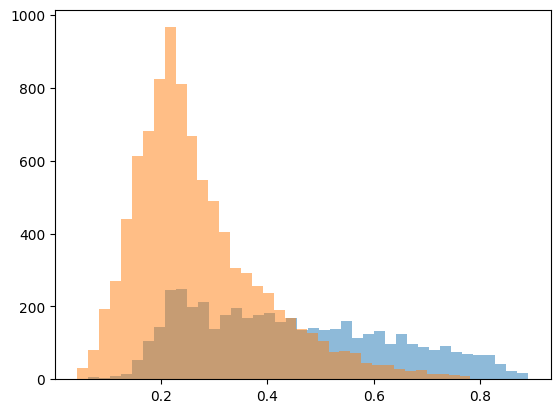

In [1323]:
plt.hist(af[af['rush_win'] == 1]['proba'], bins = 40, alpha = 0.5)
plt.hist(af[af['rush_win'] == 0]['proba'], bins = 40, alpha = 0.5)

In [100]:
likely_losses = af[af['proba'] < 0.3]
likely_wins = af[af['proba'] > 0.6]
pd.set_option('display.max_columns', None)

NameError: name 'af' is not defined

In [1397]:
likely_losses.query('stunt_type == "TT"').groupby(['frame_from_overlap'])[features].mean()

,frame_from_snap,frame_from_overlap,width_in,width_out,depth_in,depth_out,s_in,s_out,a_in,a_out,squareness_in,squareness_out,open_outside_in,open_outside_out,moving_outside_in,moving_outside_out,rotation_in,rotation_out,rotation_outside_in,rotation_outside_out,qb_o_rel_in,qb_o_rel_out,qb_squareness_in,qb_squareness_out,qb_dist_in,qb_dist_out,x_diff,y_diff,dist,min_qb_dist,rel_rotation,penetrator_depth,mean_squareness,dev_squareness,max_squareness,mean_qb_squareness,dev_qb_squareness,max_qb_squareness,exchange
frame_from_overlap,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-7,9.487310,-7.0,0.539010,1.547944,1.983706,2.179492,1.829873,1.603350,0.920228,1.271624,21.619721,18.388934,13.172970,-3.885076,101.890228,-42.919289,-1.903020,-3.420609,2.781548,-3.504264,-3.183174,-6.613509,17.914256,30.267903,4.032968,4.144942,1.008934,0.195787,1.188604,3.939853,-4.006929,1.125863,20.004327,15.733654,28.388832,24.091079,19.238720,35.174138,0.697970
-6,10.488189,-6.0,0.572861,1.494803,2.170446,2.333045,1.913701,1.716037,0.923675,1.233780,23.216719,19.915827,13.809895,-7.099659,103.269291,-51.485722,-0.254357,-3.138714,2.286063,-5.330105,-2.343893,-6.823768,19.571138,31.670813,4.063882,4.182565,0.921942,0.162598,1.135542,3.965157,-8.855171,1.398530,21.566273,17.018098,30.903176,25.620976,20.439279,37.407836,0.711286
-5,11.371831,-5.0,0.599239,1.425493,2.341352,2.463099,1.974338,1.804028,0.907099,1.167127,23.570479,21.439239,12.822648,-10.222282,102.616394,-58.085324,-0.653070,-3.477268,2.559268,-8.158620,-2.867578,-6.539758,20.185787,33.428937,4.082048,4.211583,0.826254,0.121746,1.061305,3.980478,-13.524028,1.628310,22.504859,17.776619,32.275775,26.807362,21.345206,38.998558,0.732394
-4,12.297619,-4.0,0.623631,1.358185,2.516161,2.603780,1.979970,1.848571,0.930268,1.098393,23.239077,23.074881,10.845387,-13.054583,88.270387,-67.289375,-0.119911,-3.733512,1.901399,-10.861071,-2.147129,-6.176796,20.424161,35.159859,4.117733,4.255773,0.734554,0.087619,1.021055,4.008839,-18.372708,1.865268,23.156979,18.373112,33.368750,27.792010,22.135939,40.356843,0.735119
-3,13.253125,-3.0,0.658594,1.308875,2.710187,2.760719,1.977750,1.880594,0.985719,1.026625,24.058750,25.043094,10.554937,-14.705906,85.665031,-77.341344,0.809125,-4.467594,3.478812,-13.136594,-1.801388,-7.653826,21.586841,36.546459,4.161429,4.312049,0.650281,0.050531,0.994344,4.049152,-22.484156,2.114250,24.550922,19.388469,35.125906,29.066650,23.032715,41.679115,0.753125
-2,14.179811,-2.0,0.694732,1.262240,2.879085,2.919842,1.984511,1.915741,1.073817,1.009054,25.496656,25.409779,10.924164,-15.590284,77.055804,-90.600757,0.132492,-4.441451,3.322461,-14.658170,-2.755897,-7.653303,22.806331,36.370869,4.204117,4.349372,0.567508,0.040757,0.988901,4.075134,-24.152366,2.336972,25.453218,20.086609,36.373344,29.588600,23.437656,42.465005,0.747634
-1,15.185668,-1.0,0.730098,1.212508,3.088762,3.091889,1.987687,1.917134,1.176189,1.086156,26.530033,25.768534,12.017655,-14.693420,67.303029,-93.747296,-0.201498,-4.074072,2.159870,-14.721564,-2.779934,-7.268447,24.117516,35.603715,4.222872,4.384873,0.482410,0.003127,0.997501,4.088855,-27.540391,2.572215,26.149283,20.597286,37.138567,29.860616,23.628662,42.867863,0.765472
0,16.273038,0.0,0.787509,1.228737,3.347543,3.270034,1.995734,1.887577,1.289932,1.240205,27.941570,25.683106,13.335222,-10.013413,54.035836,-77.578908,-0.403754,-2.474915,2.247235,-12.717099,-3.553814,-6.052329,24.536723,34.319907,4.210189,4.450840,0.441229,-0.077509,0.994544,4.103549,-24.645563,2.828089,26.812338,21.180102,38.246485,29.428315,23.311991,42.413032,0.771331
1,17.307958,1.0,0.793772,1.167751,3.548235,3.463875,1.941073,1.870761,1.362664,1.335225,28.597024,26.394256,13.202422,-7.117855,37.645779,-63.446228,0.644083,-2.244983,1.173979,-11.455709,-2.388923,-6.078804,25.989817,33.654696,4.231685,4.460365,0.373979,-0.084360,1.015609,4.105433,-22.148927,3.067578,27.495640,21.762265,39.450969,29.822257,23.596594,42.806517,0.764706


In [99]:
likely_wins.query('stunt_type == "TT"').groupby('frame_from_overlap')[features].mean()

NameError: name 'likely_wins' is not defined

In [ ]:
def train_test_split_TOWO(df,feature_cols,label_col,dividers,week = 8):
    test_data = df[(df['gameId'] > dividers[week-1]) &
                    (df['gameId'] < dividers[week])]
    train_data = df[(df['gameId'] < dividers[week-1]) |
                    (df['gameId'] > dividers[week])]
    return train_data[feature_cols], test_data[feature_cols], train_data[label_col], test_data[label_col]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_TOWO(pro_frames_merge_trunc,
                                                        features,
                                                        'rush_win',
                                                        divider_ids,
                                                        week = 7)
y_train